<a href="https://colab.research.google.com/github/jorgecif/CovidMisinformationDetection/blob/main/TFM_MIA_ComparacionMetodosDeteccionDesinformacionCOVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detección de desinformación relacionada con COVID19** - Comparación de modelos de aprendizaje automático y aprendizaje profundo


> Por: Jorge Orlando Cifuentes Cifuentes




**Modelos a comparar**

*   Aprendizaje automático: Naïve Bayes, Random Forest, Logistic, SVM
*   Aprendizaje profundo: Redes neuronales básicas, redes neuronales convolucionales, redes neuronales recurrentes.


### Librerías y funciones

In [1]:
# Generales
import warnings
warnings.filterwarnings('ignore')
#import csv
#import tensorflow as tf
import pandas as pd
import numpy as np
import joblib # Para exportar el modelo


# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns



# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression # Logistic
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import LinearSVC # Support Vector
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten


from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model


In [2]:
# Funciones para comparar modelos

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc']) # Modifico "acc" por "accuracy"
    plt.plot(history.history['val_acc']) # Modifico "val_acc" por "val_accuracy"
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

# Función para visualizar imagen almacenada en los datos
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

### Carga de datos

In [3]:
# Carga de datos
url_datos = 'https://github.com/jorgecif/CovidMisinformationDetection/blob/main/data/CovidHeadlinesDataset.xlsx?raw=true' # 1000 datos por categoría

datos = pd.read_excel(url_datos)

print("Se han cargado ", datos.shape[0], " noticias")

# Muestra de los datos
print(len(datos))
datos.head()


Se han cargado  21721  noticias
21721


,Text,country,lang,label,URL,date,verificado_por
0,Britain’s Death Toll from the Coronavirus Riva...,United Kingdom,English,True,https://www.snopes.com/ap/2020/05/05/britains-...,2020-02-02 00:00:00,snopes
1,Timeline Reset: CDC Confirms Weeks-Earlier Cal...,United States,English,True,https://www.snopes.com/ap/2020/04/22/timeline-...,2020-06-03 00:00:00,snopes
2,"Dentists, Hair Salons, Beaches: Lockdowns Ease...",United States,English,True,https://www.snopes.com/ap/2020/04/20/dentists-...,2020-08-03 00:00:00,snopes
3,33 Million Have Sought US Unemployment Aid Sin...,United States,English,True,https://www.snopes.com/ap/2020/05/07/33-millio...,2020-09-03 00:00:00,snopes
4,United States ‘Wasted’ Months Before Preparing...,United States,English,True,https://www.snopes.com/ap/2020/04/05/u-s-waste...,2020-03-04 00:00:00,snopes


In [4]:
# Verifico si hay valores nulos
datos.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21721 entries, 0 to 21720
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            21721 non-null  object
 1   country         21721 non-null  object
 2   lang            21721 non-null  object
 3   label           21721 non-null  bool  
 4   URL             21623 non-null  object
 5   date            15183 non-null  object
 6   verificado_por  21721 non-null  object
dtypes: bool(1), object(6)
memory usage: 1.0+ MB


In [5]:
#Elimino duplicados de todas las columnas

datos2 = datos.drop_duplicates()
print(len(datos2))

# Elimino ambiguedades

datos3=datos2.drop_duplicates(['Text'], keep='first') # Elimino ambieguedades
print(len(datos3))

20966
18696


In [6]:
# Revuelvo los registros
datos3 = datos3.sample(frac = 1, random_state= 88) 
datos3=datos3.reset_index()
datos3=datos3.drop(["index"], axis=1)

# Muestra de los datos
datos3.head(10)
#print(len(datos))

,Text,country,lang,label,URL,date,verificado_por
0,A Chinese woman in Mombasa was attacked and ki...,Kenya,English,False,https://pesacheck.org/hoax-reports-that-a-chin...,2020-03-21 00:00:00,PesaCheck
1,This video shows fishes overflowing out of th...,India,Marathi,False,https://marathi.factcrescendo.com/old-video-fr...,2020/04/22,FactCrescendo
2,Initial data from clinical trials testing whet...,United States,English,True,https://reuters.com,NaN,Reuters
3,Authorities in Moscow said a QR-code system wo...,United States,English,True,https://reuters.com,NaN,Reuters
4,Studies show the coronavirus was engineered t...,United States,English,False,https://leadstories.com/hoax-alert/2020/03/Fac...,2020/02/19,LeadStories
5,As the architect of Sweden's unorthodox respon...,United States,English,True,https://reuters.com,NaN,Reuters
6,New York schools add a COVID-19 vaccine to th...,United States,English,False,https://leadstories.com/hoax-alert/2020/05/fac...,2020/04/19,LeadStories
7,Dr Anil Jasinghe is appointed as the Vice Chai...,Sri Lanka,Sinhala,False,https://srilanka.factcrescendo.com/2020/04/06/...,2020-04-06 00:00:00,FactCrescendo
8,Diagnostic services provider LabCorp said on T...,United States,English,True,https://reuters.com,NaN,Reuters
9,"Equity indices in the green, FMCG and IT stock...",India,English,True,https://www.afghanistannews.net/news/264217872...,2020-01-22 00:00:00,afghanistannews.net


In [7]:
# Descripción de los datos

datos3.describe(include="all")

,Text,country,lang,label,URL,date,verificado_por
count,18696,18696,18696,18696,18619,12894,18696
unique,18696,127,50,2,8226,315,130
top,Photo shows food being distributed to Rwandans...,United States,English,False,https://reuters.com,2020-04-03 00:00:00,Reuters
freq,1,7637,12468,11921,5651,680,5651


### Exploración inicial de los datos

In [8]:
# Reviso las 10 primeras categorías de cada variable categórica

for col in datos3.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(datos3[col].value_counts().head(10))

----------------------------------------Text---------------------------------------- - 

Photo shows food being distributed to Rwandans during coronavirus lockdown.                                                                                                                                                                                  1
The World Health Organization on Tuesday acknowledged "evidence emerging" of the airborne spread of the novel coronavirus, after a group of scientists urged the global body to update its guidance on how the respiratory disease passes between people.    1
Brazil's total COVID-19 death toll blew past that of Italy on Thursday, as the Health Ministry reported 1,437 deaths in the last 24 hours and 30,925 additional coronavirus cases.                                                                           1
 Japanese Nobel laureate Tasuku Honjo, who worked in Wuhan for four years, claimed that SARS-CoV-2 was human-made.                                                                                                                         

----------------------------------------country---------------------------------------- - 

United States    7637
India            2380
Spain             889
Brazil            714
France            500
Philippines       385
Colombia          340
Australia         302
Italy             298
China             289
Name: country, dtype: int64

----------------------------------------lang---------------------------------------- - 

English       12468
Spanish        1808
Portuguese      690
French          601
tl              505
Hindi           280
Italian         222
Arabic          136
Indonesian      115
Malayalam       114
Name: lang, dtype: int64

----------------------------------------label---------------------------------------- - 

False    11921
True      6775
Name: label, dtype: int64

----------------------------------------URL---------------------------------------- - 

https://reuters.com                                                                                                                              5651
http://www.ecuadorchequea.com/las-mentiras-sobre-el-covid-19-en-ecuador/                                                                           14
https://observers.france24.com/fr/20200130-intox-chine-soupe-chauve-souris-rumeur-origine-coronavirus                                               7
http://news.jtbc.joins.com/html/040/NB11932040.html                                                                                                 5
https://factcheck.afp.com/story-originated-parody-account-no-driver-threatening-spread-covid-19-across-nigeria                                      4
https://factcheck.afp.com/graphic-purported-quote-philippine-vice-president-leni-robredo-has-been-doctored                                          4
https://piaui.folha.uol.com.br/lupa/2020/01/27/verificamos-coronavirus-infectou-28-milhoes-matou-112

----------------------------------------date---------------------------------------- - 

2020-04-03 00:00:00    680
2020-03-17 00:00:00    126
2020-04-02 00:00:00    126
2020/03/17             126
2020-03-23 00:00:00    125
2020-03-16 00:00:00    124
2020/03/23             117
2020-03-27 00:00:00    114
2020-03-24 00:00:00    113
2020/04/02             111
Name: date, dtype: int64

----------------------------------------verificado_por---------------------------------------- - 

Reuters                5651
AFP                     971
FactCrescendo           759
PolitiFact              543
Factly                  428
adelaidenow.au          413
BOOM FactCheck          404
LeadStories             399
Maldita.es              386
afghanistannews.net     355
Name: verificado_por, dtype: int64

In [9]:
# Filtro primeros 10 de cada variable 

verificado_10=datos3["verificado_por"].value_counts().head(10)
lang_10=datos3["lang"].value_counts().head(10)
country_10=datos3["country"].value_counts().head(10)

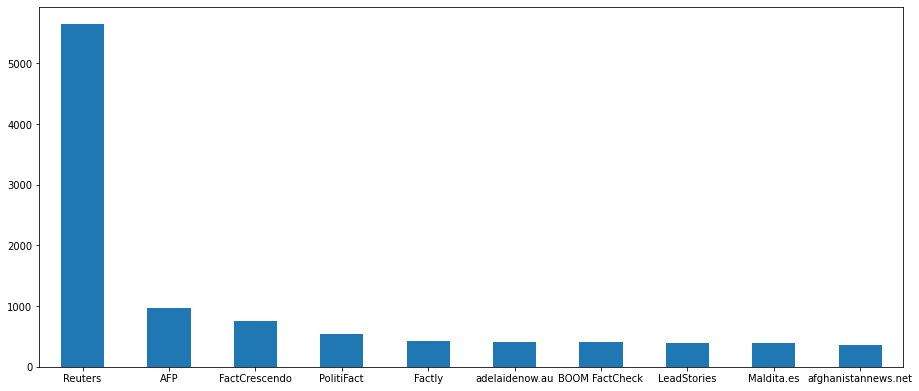

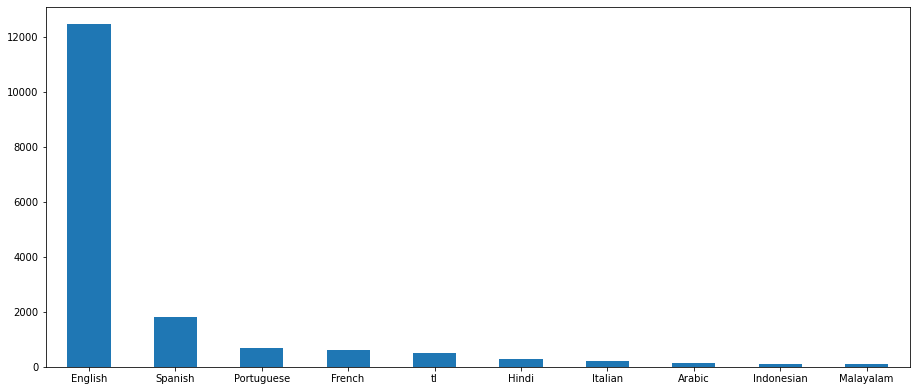

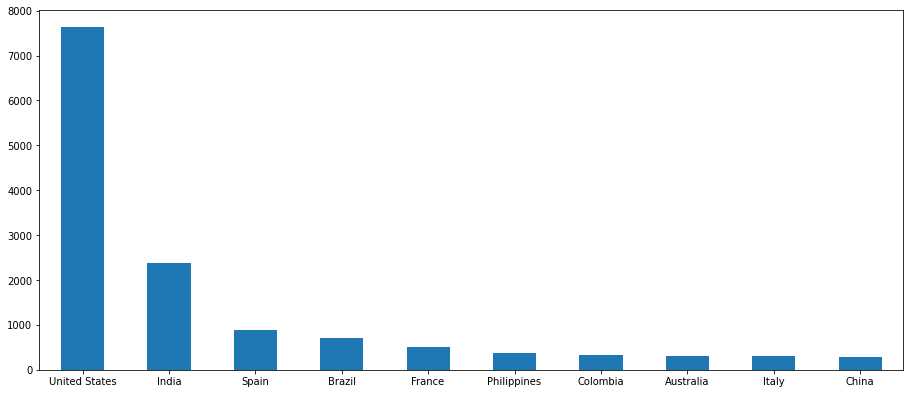

In [10]:
# Grafico datos

fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
ax = verificado_10.plot.bar(x='lab', y='val', rot=0)

fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
ax = lang_10.plot.bar(x='lab', y='val', rot=0)

fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
ax = country_10.plot.bar(x='lab', y='val', rot=0)

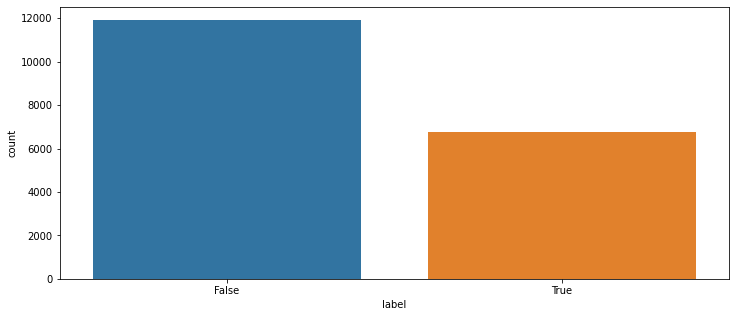

In [11]:
# Distribución de las categorías datos
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos3)
plt.show()

In [12]:
# Filtro datos sólo en inglés
datos_ingles=datos3[datos3['lang']=="English"]
len(datos_ingles)

12468

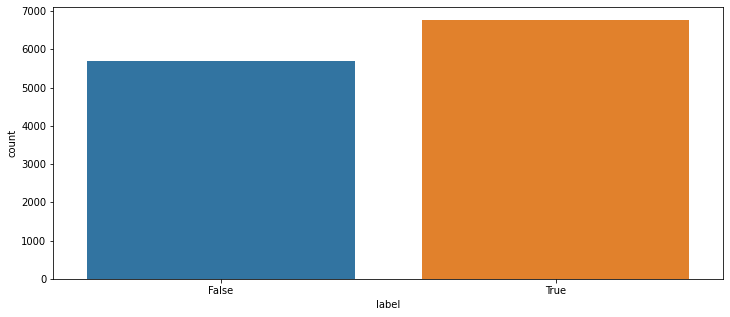

In [13]:
# Distribución de las categorías datos de trabajo filtrados en idioma inglés
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos_ingles)
plt.show()

### Creación de conjuntos de datos

In [14]:
# Reservo unos datos para pruebas finales (datos que no se tocan)

datos_trabajo,datos_reserva = train_test_split(datos_ingles, test_size=0.1, random_state=88 )
datos_trabajo=datos_trabajo.reset_index()
datos_trabajo=datos_trabajo.drop(["index"], axis=1)

datos_reserva=datos_reserva.reset_index()
datos_reserva=datos_reserva.drop(["index"], axis=1)

print("Datos para trabajar: ", len(datos_trabajo))
print("Datos reservados para pruebas finales ", len(datos_reserva))



Datos para trabajar:  11221
Datos reservados para pruebas finales  1247


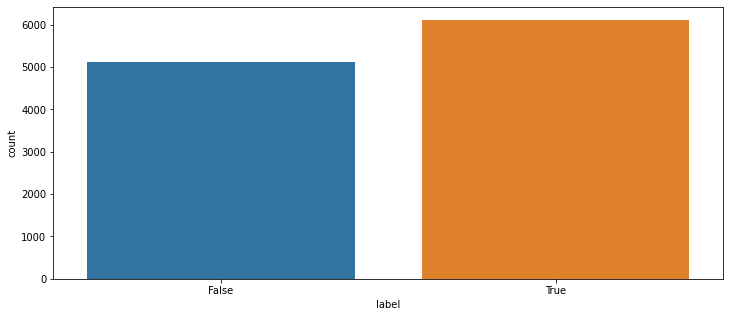

In [15]:
# Distribución de las categorías datos de trabajo
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos_trabajo)
plt.show()

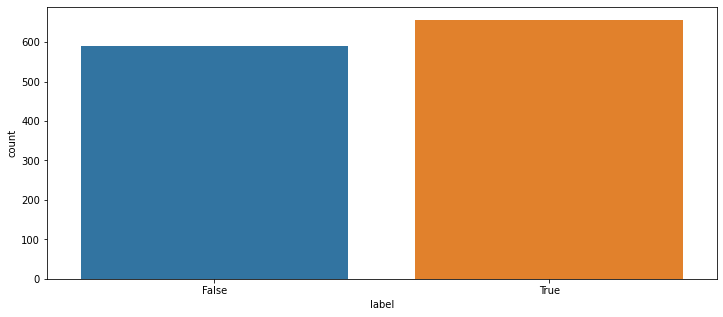

In [16]:
# Distribución de las categorías datos reservados
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos_reserva)
plt.show()

In [17]:
datos_trabajo.head(10)

,Text,country,lang,label,URL,date,verificado_por
0,"Britain is not ""anywhere close"" to the scenari...",United States,English,True,https://reuters.com,NaN,Reuters
1,A video of Chinese people fighting for Muslim...,Indonesia,English,False,https://s.id/fhqAe,2020/03/12,TEMPO
2,The reproductive number of COVID-19 in England...,United States,English,True,https://reuters.com,NaN,Reuters
3,Peru's miners are revving up stalled operation...,United States,English,True,https://reuters.com,NaN,Reuters
4,More than 150 patients were evacuated on Satur...,United States,English,True,https://reuters.com,NaN,Reuters
5,Thai department of health published an infogr...,Thailand,English,False,http://u.afp.com/ThaiFaceMasks,2020/02/07,AFP
6,A picture claims that an Italian man committe...,India,English,False,https://www.boomlive.in/fake-news/dated-photos...,2020/03/26,BOOM FactCheck
7,Viral picture message in Nigeria suggests form...,Nigeria,English,False,https://dubawa.org/and-another-one-what-did-ob...,2020-03-02 00:00:00,Dubawa
8,Publication broadcasts a video of “the market ...,North Macedonia,English,False,https://truthmeter.mk/the-market-of-terror-is-...,2020-01-30 00:00:00,Vistinomer
9,Diagnostic services provider LabCorp said on T...,United States,English,True,https://reuters.com,NaN,Reuters


###  Preparación de los datos

In [18]:
# Convierto categorías en números - datos de trabajo

category_dict = {value:index for index, value in enumerate(datos_trabajo["label"].unique())} # Extraigo categorías de todos los datos


# Extraigo datos de titulares
corpus_trabajo = datos_trabajo["Text"]
results_trabajo = datos_trabajo["label"].map(category_dict)
#category_dict_trabajo
datos_trabajo["label"]

0         True
1        False
2         True
3         True
4         True
         ...  
11216    False
11217    False
11218    False
11219     True
11220     True
Name: label, Length: 11221, dtype: bool

In [19]:
category_dict

{False: 1, True: 0}

In [20]:
corpus_trabajo

0        Britain is not "anywhere close" to the scenari...
1         A video of Chinese people fighting for Muslim...
2        The reproductive number of COVID-19 in England...
3        Peru's miners are revving up stalled operation...
4        More than 150 patients were evacuated on Satur...
                               ...                        
11216    A Twitter post claimed Cristiano Ronaldo is tr...
11217     News graphic saying Indian prime minister has...
11218     The WHO declared COVID-19 is the abbreviation...
11219    The toilet paper panic has officially spread.W...
11220    The U.S. government on Wednesday said it will ...
Name: Text, Length: 11221, dtype: object

In [21]:
# Convierto categorías en números - datos de trabajo

# Extraigo datos de titulares
corpus_trabajo = datos_trabajo["Text"]
results_trabajo = datos_trabajo["label"].map(category_dict)
#category_dict_trabajo
datos_trabajo["label"]

0         True
1        False
2         True
3         True
4         True
         ...  
11216    False
11217    False
11218    False
11219     True
11220     True
Name: label, Length: 11221, dtype: bool

In [22]:
results_trabajo

0        0
1        1
2        0
3        0
4        0
        ..
11216    1
11217    1
11218    1
11219    0
11220    0
Name: label, Length: 11221, dtype: int64

In [23]:
# Convierto categorías en números - datos de reserva

# Extraigo datos de titulares
corpus_reserva = datos_reserva["Text"]

# Construyo mapa de categorías
results_reserva = datos_reserva["label"].map(category_dict) # Mapeo categorías con el mismo diccionario (category_dict)

In [24]:
datos_reserva["label"]

0       False
1        True
2       False
3       False
4       False
        ...  
1242     True
1243     True
1244    False
1245     True
1246     True
Name: label, Length: 1247, dtype: bool

In [25]:
results_reserva

0       1
1       0
2       1
3       1
4       1
       ..
1242    0
1243    0
1244    1
1245    0
1246    0
Name: label, Length: 1247, dtype: int64

In [26]:
# Parámetros
n_most_common_words = 10000
max_len = 300


# Creo tokenizador con todos los datos
corpus = datos3["Text"]
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(corpus.values)
word_index = tokenizer.word_index
print('Se encontraron %s tokens únicos' % len(word_index))

Se encontraron 28811 tokens únicos


In [27]:
# Tokenización datos de trabajo

corpus_trabajo = datos_trabajo["Text"]
sequences = tokenizer.texts_to_sequences(corpus_trabajo.values)
X = pad_sequences(sequences, maxlen=max_len)

In [28]:
# Tokenización datos de reserva para pruebas

corpus_reserva = datos_reserva["Text"]
sequences_reserva = tokenizer.texts_to_sequences(corpus_reserva.values)
X_reserva = pad_sequences(sequences_reserva, maxlen=max_len)

In [29]:
X_reserva[120]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Train - Test split

In [30]:
# Train - Test Split

x_train,x_test, y_train,y_test = train_test_split(X, results_trabajo, test_size=0.2, random_state=88 )

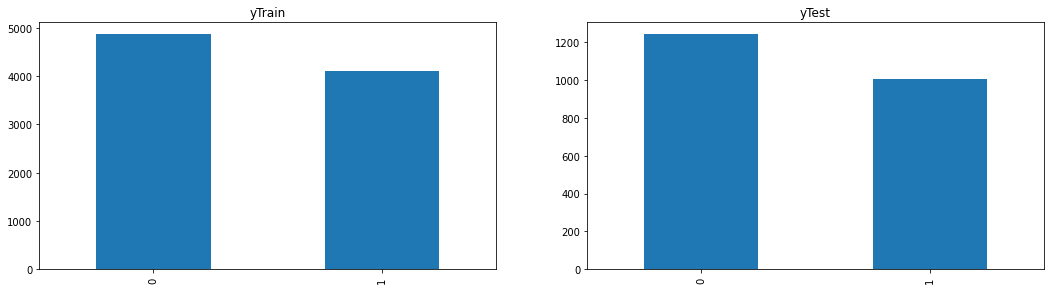

In [31]:
# Visualizo el balance de las clases luego de la división para verificar que no exista un desbalance
df_y_train = pd.DataFrame({'yTrain': y_train})

df_y_test = pd.DataFrame({'yTest': y_test})


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 10))
plt.subplot(2, 2, 1).set_title('yTrain')
df_y_train["yTrain"].value_counts().plot(kind='bar')

plt.subplot(2, 2, 2).set_title('yTest')
df_y_test["yTest"].value_counts().plot(kind='bar')

### Comparación de modelos de aprendizaje automático


In [32]:
# Comparación de modelos
# Listado de modelos
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ]

In [33]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

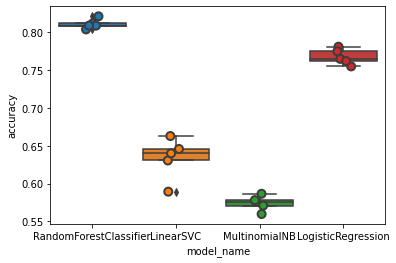

In [34]:
# Gráfico comparativo de la precisión estimada de los modelos
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#### Modelo Random Forest

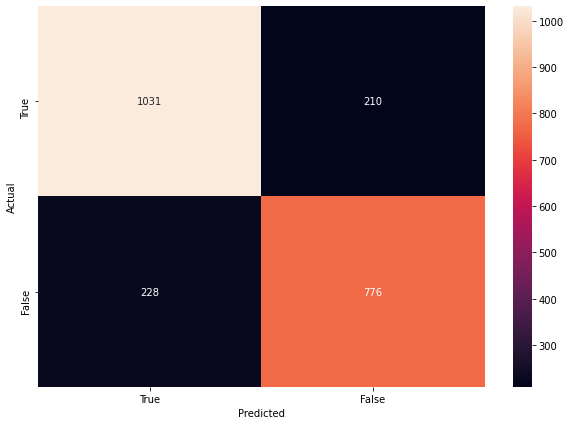

In [35]:
# Modelo RandomForest
from sklearn.metrics import confusion_matrix

modelRF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
modelRF.fit(x_train, y_train)
y_pred = modelRF.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_dict, yticklabels=category_dict)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Modelo logistic

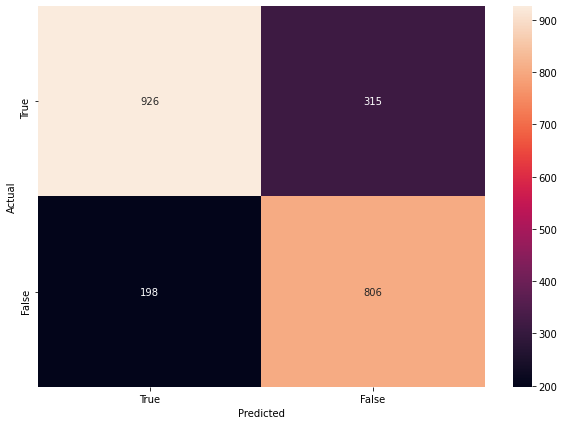

In [36]:
# Modelo Logistic
from sklearn.metrics import confusion_matrix

modelLOG = LogisticRegression(random_state=0)
modelLOG.fit(x_train, y_train)
y_pred = modelLOG.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_dict, yticklabels=category_dict)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Modelo vector de soporte lineal

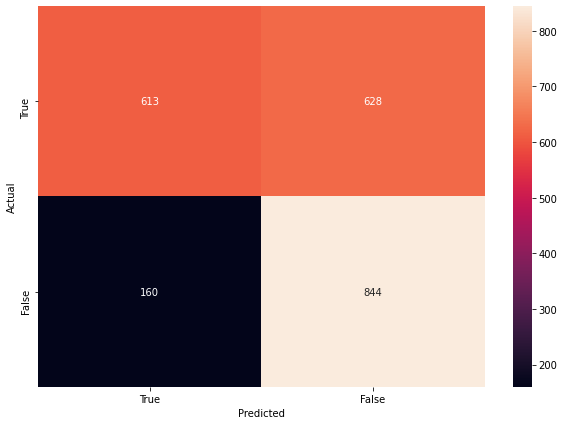

In [37]:
# Modelo Vector Soporte Lineal
from sklearn.metrics import confusion_matrix

modelSVC = LinearSVC()
modelSVC.fit(x_train, y_train)
y_pred = modelSVC.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_dict, yticklabels=category_dict)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Modelo Naïve Bayes

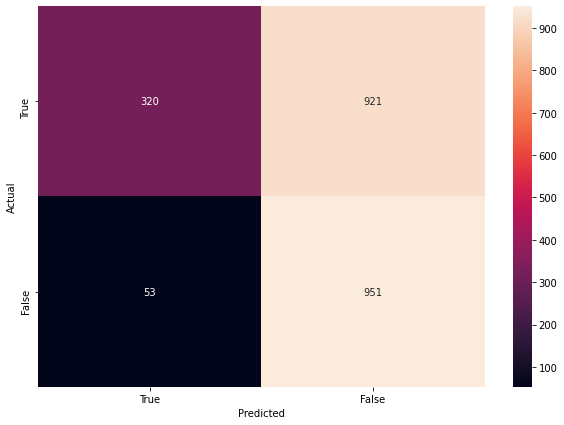

In [38]:
# Modelo Multinomial Naive Bayes
from sklearn.metrics import confusion_matrix

modelNB = MultinomialNB()
modelNB.fit(x_train, y_train)
y_pred = modelNB.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_dict, yticklabels=category_dict)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Prueba de modelos de aprendizaje automático

In [39]:
datos_reserva[datos_reserva["label"]==True].head(29)

,Text,country,lang,label,URL,date,verificado_por
1,The reproduction rate for the coronavirus in G...,United States,English,True,https://reuters.com,NaN,Reuters
5,The U.S. Centers for Disease Control and Preve...,United States,English,True,https://reuters.com,NaN,Reuters
6,Brazil's health regulator Anvisa on Tuesday au...,United States,English,True,https://reuters.com,NaN,Reuters
13,Southwest Airlines said on Wednesday it was e...,United States,English,True,https://reuters.com,NaN,Reuters
16,The United Kingdom's chief medical officers ha...,United States,English,True,https://reuters.com,NaN,Reuters
19,"One January lunchtime in a car parts company, ...",United States,English,True,https://reuters.com,NaN,Reuters
20,China Virus Toll Rises to Nine As Pandemic Fea...,China,English,True,https://www.afghanistannews.net/news/263789036...,2020-03-02 00:00:00,afghanistannews.net
23,French healthcare workers protested against ex...,United States,English,True,https://reuters.com,NaN,Reuters
24,Several large drugmakers including Merck & Co ...,United States,English,True,https://reuters.com,NaN,Reuters
26,"Singapore's Tychan, a biotechnology firm backe...",United States,English,True,https://reuters.com,NaN,Reuters


In [40]:
datos_reserva.head(29)

,Text,country,lang,label,URL,date,verificado_por
0,Existence of a vaccination summit may be a si...,Georgia,English,False,http://mythdetector.ge/en/myth/are-vaccines-te...,2020/06/11,Myth Detector
1,The reproduction rate for the coronavirus in G...,United States,English,True,https://reuters.com,NaN,Reuters
2,"3,500 Italians potentially infected with the n...",Brazil,English,False,https://aosfatos.org/noticias/e-falso-que-3500...,2020-02-29 00:00:00,Aos Fatos
3,The Indian Army has been called to control sev...,India,English,False,https://www.boomlive.in/fake-news/false-army-c...,2020-04-03 00:00:00,BOOM FactCheck
4,Says Queen Elizabeth said Philippine President...,United States,English,False,https://www.politifact.com/factchecks/2020/apr...,2020-04-06 00:00:00,PolitiFact
5,The U.S. Centers for Disease Control and Preve...,United States,English,True,https://reuters.com,NaN,Reuters
6,Brazil's health regulator Anvisa on Tuesday au...,United States,English,True,https://reuters.com,NaN,Reuters
7,Ugandan President Kaguta Museveni and Prime M...,Uganda,English,False,https://pesacheck.org/false-ugandan-president-...,2020/06/09,PesaCheck
8,A video has been viewed thousands of times on...,Malaysia,English,False,https://factcheck.afp.com/video-shows-safety-d...,2020/04/09,AFP
9,“Bill Gates Explains That The COVID Vaccine W...,United States,English,False,https://www.politifact.com/factchecks/2020/may...,2020/05/20,PolitiFact


In [41]:
# Prueba con textos de datos de reserva

text1=datos_reserva["Text"][15]
text2=datos_reserva["Text"][25]
text3=datos_reserva["Text"][57]

print("Texto 1: ", text1)
print("Categoria real: ",datos_trabajo["label"][15])

print("Texto 2: ", text2)
print("Categoria real: ",datos_reserva["label"][25])

print("Texto 3: ", text3)
print("Categoria real: ",datos_reserva["label"][57])

Texto 1:   Having a beard increases your chances of getting coronavirus.
Categoria real:  False
Texto 2:   China “stole coronavirus from Canada and weaponized it into a Bioweapon.”
Categoria real:  False
Texto 3:  India reported a record daily increase of novel coronavirus cases on Friday and became the world's fourth worst-hit country, raising the prospect of the return of a lockdown just days after it was lifted.
Categoria real:  True


In [42]:
datos_reserva.head(6)

,Text,country,lang,label,URL,date,verificado_por
0,Existence of a vaccination summit may be a si...,Georgia,English,False,http://mythdetector.ge/en/myth/are-vaccines-te...,2020/06/11,Myth Detector
1,The reproduction rate for the coronavirus in G...,United States,English,True,https://reuters.com,NaN,Reuters
2,"3,500 Italians potentially infected with the n...",Brazil,English,False,https://aosfatos.org/noticias/e-falso-que-3500...,2020-02-29 00:00:00,Aos Fatos
3,The Indian Army has been called to control sev...,India,English,False,https://www.boomlive.in/fake-news/false-army-c...,2020-04-03 00:00:00,BOOM FactCheck
4,Says Queen Elizabeth said Philippine President...,United States,English,False,https://www.politifact.com/factchecks/2020/apr...,2020-04-06 00:00:00,PolitiFact
5,The U.S. Centers for Disease Control and Preve...,United States,English,True,https://reuters.com,NaN,Reuters


In [43]:
# Función para prueba

def news_alert(a, modelo_probar):
    clf=modelo_probar
    # Tokenizacion
    corpus_1=[]
    corpus_1.append(a)
    corpus_2=pd.Series(corpus_1)
    sequences_reserva = tokenizer.texts_to_sequences(corpus_2.values)
    transform_vect_reserva= pad_sequences(sequences_reserva, maxlen=max_len)
    #print(transform_vect_reserva)
    
    prediccion=clf.predict(transform_vect_reserva)
    prediccion_a = [np.array(prediccion)]
    print(prediccion)    

    if prediccion == 1:
       print("Alerta")
    else:
      print("No alerta")

In [44]:
clasificar_texto=text2
print(clasificar_texto)

print("Modelo RF")
print(news_alert(clasificar_texto, modelRF))

 China “stole coronavirus from Canada and weaponized it into a Bioweapon.”
Modelo RF
[1]
Alerta
None


In [45]:
# Prueba con función

# 1 alerta
# 0 no alerta

clasificar_texto=text1
print(clasificar_texto)

print("Modelo RF")
print(news_alert(clasificar_texto, modelRF))

print(" ")
print("Modelo LOG")
print(news_alert(clasificar_texto, modelLOG))

print(" ")
print("Modelo SVC")
print(news_alert(clasificar_texto, modelSVC))

print(" ")
print("Modelo NB")
print(news_alert(clasificar_texto, modelNB))


 Having a beard increases your chances of getting coronavirus.
Modelo RF
[1]
Alerta
None
 
Modelo LOG
[1]
Alerta
None
 
Modelo SVC
[1]
Alerta
None
 
Modelo NB
[1]
Alerta
None


In [46]:
news_alert(clasificar_texto, modelLOG)

[1]
Alerta


#### Generación de archivos de modelos de aprendizaje automático

In [47]:
## Guardo los modelos en archivos


filename = 'SVC_model.pkl'
joblib.dump(modelSVC, filename)

filename = 'NB_model.pkl'
joblib.dump(modelNB, filename)

filename = 'LOG_model.pkl'
joblib.dump(modelLOG, filename)

filename = 'RF_model.pkl'
joblib.dump(modelRF, filename)

filename = 'tokenizer.pkl'
joblib.dump(tokenizer, filename)


['tokenizer.pkl']

### Comparación de modelos de aprendizaje profundo

#### Modelo base inicial

In [48]:
# Parámetros de la red
epochs = 10
emb_dim = 128
batch_size = 32

In [49]:
# Creación del modelo y compilación

model_base = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_base.summary()

# Compilación

model_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 153604    
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 1,433,629
Trainable params: 1,433,629
Non-trainable params: 0
______________________________________________

In [50]:
# Entrenamiento

history_base = model_base.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Epoch 1/10
225/225 [==============================] - 4s 16ms/step - loss: 0.6765 - acc: 0.5405 - val_loss: 0.6674 - val_acc: 0.5496
Epoch 2/10
225/225 [==============================] - 3s 15ms/step - loss: 0.6712 - acc: 0.5408 - val_loss: 0.6672 - val_acc: 0.5496
Epoch 3/10
225/225 [==============================] - 3s 15ms/step - loss: 0.6717 - acc: 0.5408 - val_loss: 0.6671 - val_acc: 0.5496
Epoch 4/10
225/225 [==============================] - 3s 15ms/step - loss: 0.6704 - acc: 0.5408 - val_loss: 0.6672 - val_acc: 0.5496
Epoch 5/10
225/225 [==============================] - 3s 15ms/step - loss: 0.6702 - acc: 0.5408 - val_loss: 0.6671 - val_acc: 0.5496
Epoch 6/10
225/225 [==============================] - 4s 16ms/step - loss: 0.6709 - acc: 0.5408 - val_loss: 0.6672 - val_acc: 0.5496
Epoch 7/10
225/225 [==============================] - 3s 15ms/step - loss: 0.6698 - acc: 0.5408 - val_loss: 0.6672 - val_acc: 0.5496
Epoch 8/10
225/225 [==============================] - 4s 16ms/step - 

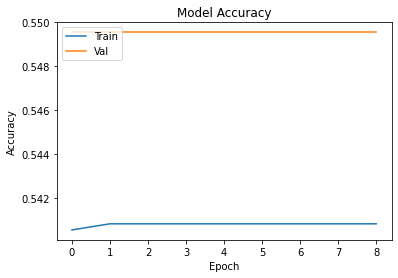

In [51]:
# Resultados

# Accuracy
plot_acc(history_base)

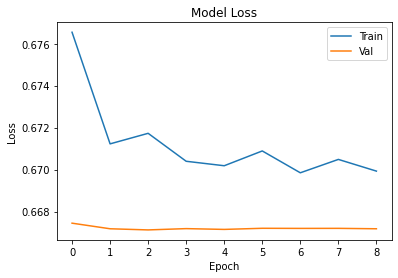

In [52]:
# Loss
plot_loss(history_base)

#### Modelo redes convolucionales - CNN

In [53]:
# Parámetros de la red
epochs = 20
emb_dim = 128
batch_size = 32

In [54]:
# Creación del modelo y compilación

model_CNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.Conv1D(128, 4, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_CNN.summary()

# Compilación

model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 297, 128)          65664     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [55]:
# Entrenamiento

history_CNN = model_CNN.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Epoch 1/20
225/225 [==============================] - 23s 101ms/step - loss: 0.2945 - acc: 0.8603 - val_loss: 0.1246 - val_acc: 0.9538
Epoch 2/20
225/225 [==============================] - 22s 99ms/step - loss: 0.0722 - acc: 0.9756 - val_loss: 0.1182 - val_acc: 0.9555
Epoch 3/20
225/225 [==============================] - 22s 99ms/step - loss: 0.0170 - acc: 0.9948 - val_loss: 0.1372 - val_acc: 0.9605
Epoch 4/20
225/225 [==============================] - 23s 100ms/step - loss: 0.0051 - acc: 0.9989 - val_loss: 0.1557 - val_acc: 0.9605
Epoch 5/20
225/225 [==============================] - 22s 99ms/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.1644 - val_acc: 0.9633
Epoch 6/20
225/225 [==============================] - 22s 100ms/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.1759 - val_acc: 0.9649
Epoch 7/20
225/225 [==============================] - 22s 100ms/step - loss: 0.0014 - acc: 0.9999 - val_loss: 0.1804 - val_acc: 0.9627
Epoch 8/20
225/225 [==============================] - 24s 

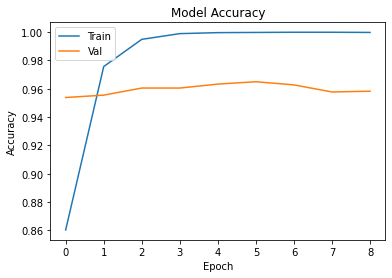

In [56]:
# Resultados

# Accuracy
plot_acc(history_CNN)

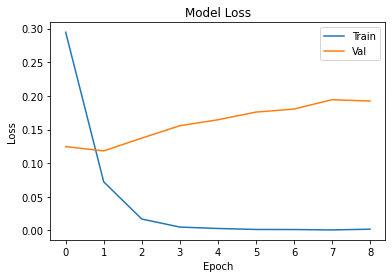

In [57]:
# Loss

plot_loss(history_CNN)

#### Modelo redes recurrentes - RNN

In [58]:
# Parámetros de la red
epochs = 20
emb_dim = 128
batch_size = 32

In [59]:
# Creación del modelo y compilación

model_RNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.7),
    tf.keras.layers.LSTM(64, dropout=0.7, recurrent_dropout=0.7),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_RNN.summary()

# Compilación

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 128)          1280000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [60]:
# Entrenamiento

history_RNN = model_RNN.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Epoch 1/20
225/225 [==============================] - 96s 426ms/step - loss: 0.3972 - acc: 0.8221 - val_loss: 0.1953 - val_acc: 0.9287
Epoch 2/20
225/225 [==============================] - 96s 424ms/step - loss: 0.2026 - acc: 0.9220 - val_loss: 0.1565 - val_acc: 0.9393
Epoch 3/20
225/225 [==============================] - 95s 421ms/step - loss: 0.1548 - acc: 0.9404 - val_loss: 0.1177 - val_acc: 0.9577
Epoch 4/20
225/225 [==============================] - 95s 421ms/step - loss: 0.1254 - acc: 0.9533 - val_loss: 0.1095 - val_acc: 0.9610
Epoch 5/20
225/225 [==============================] - 94s 419ms/step - loss: 0.1029 - acc: 0.9625 - val_loss: 0.0965 - val_acc: 0.9655
Epoch 6/20
225/225 [==============================] - 94s 419ms/step - loss: 0.0889 - acc: 0.9652 - val_loss: 0.1007 - val_acc: 0.9621
Epoch 7/20
225/225 [==============================] - 94s 418ms/step - loss: 0.0816 - acc: 0.9716 - val_loss: 0.0905 - val_acc: 0.9655
Epoch 8/20
225/225 [==============================] - 9

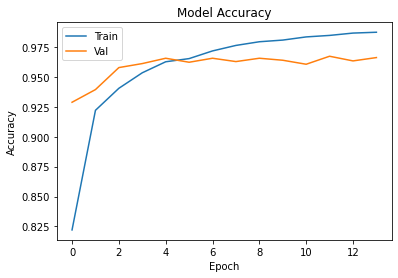

In [61]:
# Resultados

# Accuracy
plot_acc(history_RNN)

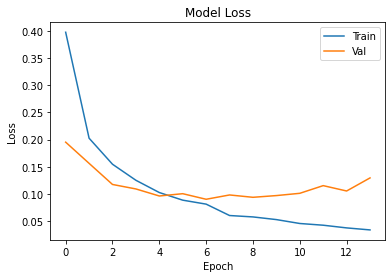

In [62]:
# Loss

plot_loss(history_RNN)

#### Comparación de los modelos

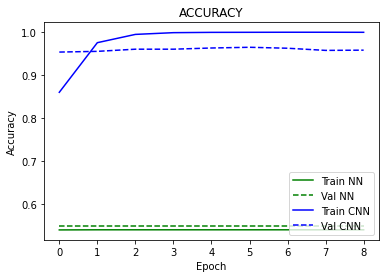

In [63]:
# Comparación Base vs CNN - Accuracy
plot_compare_accs(history_base, history_CNN, 'NN', 'CNN', 'ACCURACY')

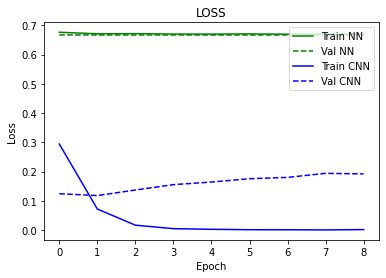

In [64]:
# Comparación Base vs CNN - Loss
plot_compare_losses(history_base, history_CNN, 'NN', 'CNN', 'LOSS')

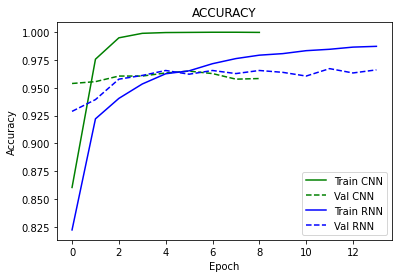

In [65]:
# Comparación CNN vs RNN - Accuracy
plot_compare_accs(history_CNN, history_RNN, 'CNN', 'RNN', 'ACCURACY')

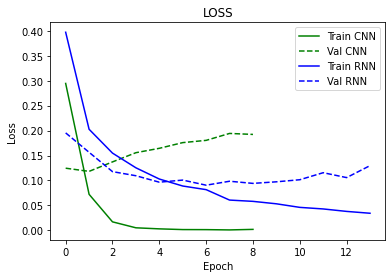

In [66]:
# Comparación CNN vs RNN - Loss
plot_compare_losses(history_CNN, history_RNN, 'CNN', 'RNN', 'LOSS')

#### Prueba de modelos de aprendizaje profundo

In [67]:
# Prueba con textos de datos de reserva

text1=datos_reserva["Text"][120]
text2=datos_reserva["Text"][18]
text3=datos_reserva["Text"][88]

print("Texto 1: ", text1)
print("Categoria real: ",datos_reserva["label"][120])

print("Texto 2: ", text2)
print("Categoria real: ",datos_reserva["label"][18])

print("Texto 3: ", text3)
print("Categoria real: ",datos_reserva["label"][88])

Texto 1:  Nearly 300,000 more people have died in the United States in 2020 during the coronavirus pandemic than would be expected based on historical trends, with at least two-thirds due to COVID-19, a government report released on Tuesday showed, adding that COVID deaths likely were undercounted.
Categoria real:  True
Texto 2:  A video purportedly showing COVID-19 victims in body bags strewn across the floor of a New York hospital was shared several thousand times in multiple languages on social media.
Categoria real:  False
Texto 3:  New cases of COVID-19 in England were rising by around 35,200 per day last week, up from 27,900 the week before, although there were tentative signs of a levelling-off around this rate, an official estimate showed on Friday.
Categoria real:  True


In [68]:
# Función para prueba

def news_alert(a, modelo_probar):
    clf=modelo_probar
    # Tokenizacion
    corpus_1=[]
    corpus_1.append(a)
    corpus_2=pd.Series(corpus_1)
    sequences_reserva = tokenizer.texts_to_sequences(corpus_2.values)
    transform_vect_reserva= pad_sequences(sequences_reserva, maxlen=max_len)
    #print(transform_vect_reserva)
    
    prediccion=clf.predict(transform_vect_reserva)
    prediccion_a = [np.array(prediccion)]
    print(prediccion)    

    if prediccion > 0.5:
       print("Alerta")
    else:
      print("No alerta")

In [69]:
# Prueba Única

test=datos_reserva["Text"][18]
  
corpus_t=[]
corpus_t.append(test)
corpus_t=pd.Series(corpus_t)
  
  
sequences_reserva = tokenizer.texts_to_sequences(corpus_t.values)
transform_vect_reserva= pad_sequences(sequences_reserva, maxlen=max_len)

transform_vect_reserva

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [70]:
datos_reserva["Text"][18]

'A video purportedly showing COVID-19 victims in body bags strewn across the floor of a New York hospital was shared several thousand times in multiple languages on social media.'

In [71]:
transform_vect_reserva

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [72]:
X_reserva[120]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [73]:
prediccion222=model_base.predict(transform_vect_reserva)

In [74]:
len(prediccion222[0])

1

In [75]:
model_RNN.predict(transform_vect_reserva)

array([[0.99997294]], dtype=float32)

In [76]:
# Prueba con función

clasificar_texto=text2
print(clasificar_texto)

print("Modelo NN")
print(news_alert(clasificar_texto, model_base))

print(" ")
print("Modelo CNN")
print(news_alert(clasificar_texto, model_CNN))

print(" ")
print("Modelo RNN")
print(news_alert(clasificar_texto, model_RNN))

A video purportedly showing COVID-19 victims in body bags strewn across the floor of a New York hospital was shared several thousand times in multiple languages on social media.
Modelo NN
[[0.4744293]]
No alerta
None
 
Modelo CNN
[[0.99999964]]
Alerta
None
 
Modelo RNN
[[0.99997294]]
Alerta
None


#### Generación de archivos de modelos de aprendizaje profundo

In [77]:
## Guardo los modelos en archivos


model_base.save('model_base.h5') 

model_CNN.save('model_CNN.h5') 

model_RNN.save('model_RNN.h5') 